In [1]:
import mediapipe as mp
import cv2
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
import time
import math
import matplotlib.pyplot as plt
import os

In [2]:
class KeypointDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        self.X = self.data.drop(columns=['label']).values.astype(np.float32)
        self.y = self.data['label'].values.astype(np.int64)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx])
        y = torch.tensor(self.y[idx])
        return X, y

In [3]:
# 하이퍼파라미퍼 튜님

batch_size = 32
learning_rate = 0.0001
num_epochs = 2000
dropout_n = 0.5

In [4]:
class KeypointClassifier(nn.Module):
    def __init__(self, input_size=99, hidden_size=128, num_classes=2):
        super(KeypointClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout_n)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [5]:
# Load Dataset and Split
dataset = KeypointDataset("keypoints_dataset.csv")
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [6]:
model = KeypointClassifier()
ce = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)


for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in dataloader_train:
        optimizer.zero_grad()
        # scheduler.step()
        logits = model(images)
        loss = ce(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")

epoch 1/2000, Loss: 2.7838
epoch 2/2000, Loss: 2.7522
epoch 3/2000, Loss: 2.7579
epoch 4/2000, Loss: 2.7726
epoch 5/2000, Loss: 2.7972
epoch 6/2000, Loss: 2.7950
epoch 7/2000, Loss: 2.7973
epoch 8/2000, Loss: 2.7685
epoch 9/2000, Loss: 2.7583
epoch 10/2000, Loss: 2.7551
epoch 11/2000, Loss: 2.8355
epoch 12/2000, Loss: 2.8423
epoch 13/2000, Loss: 2.7993
epoch 14/2000, Loss: 2.7133
epoch 15/2000, Loss: 2.8199
epoch 16/2000, Loss: 2.7618
epoch 17/2000, Loss: 2.7754
epoch 18/2000, Loss: 2.7304
epoch 19/2000, Loss: 2.7922
epoch 20/2000, Loss: 2.7544
epoch 21/2000, Loss: 2.7341
epoch 22/2000, Loss: 2.7744
epoch 23/2000, Loss: 2.7870
epoch 24/2000, Loss: 2.7600
epoch 25/2000, Loss: 2.7426
epoch 26/2000, Loss: 2.7467
epoch 27/2000, Loss: 2.7705
epoch 28/2000, Loss: 2.7358
epoch 29/2000, Loss: 2.7544
epoch 30/2000, Loss: 2.7095
epoch 31/2000, Loss: 2.7802
epoch 32/2000, Loss: 2.7268
epoch 33/2000, Loss: 2.7136
epoch 34/2000, Loss: 2.7627
epoch 35/2000, Loss: 2.7549
epoch 36/2000, Loss: 2.7758
e

In [7]:
@torch.no_grad()
def validate(f, dataloader):
    num_correct = 0
    num_total = 0
    for images, labels in dataloader:
        # images = images.to(device)
        # labels = labels.to(device)
        logits = f(images)
        prediction = logits.argmax(dim=1)
        num_correct += (prediction == labels).type(torch.float).sum().item()
        num_total += len(labels)
    return num_correct / num_total

Epoch 1/2000, Loss: 2.7408
Epoch 2/2000, Loss: 2.7795
Epoch 3/2000, Loss: 2.7399
Epoch 4/2000, Loss: 2.8196
Epoch 5/2000, Loss: 2.7570
Epoch 6/2000, Loss: 2.7652
Epoch 7/2000, Loss: 2.7470
Epoch 8/2000, Loss: 2.7114
Epoch 9/2000, Loss: 2.6963
Epoch 10/2000, Loss: 2.7488
Epoch 11/2000, Loss: 2.7877
Epoch 12/2000, Loss: 2.7797
Epoch 13/2000, Loss: 2.8058
Epoch 14/2000, Loss: 2.7393
Epoch 15/2000, Loss: 2.7662
Epoch 16/2000, Loss: 2.7713
Epoch 17/2000, Loss: 2.7616
Epoch 18/2000, Loss: 2.7503
Epoch 19/2000, Loss: 2.6833
Epoch 20/2000, Loss: 2.7981
Epoch 21/2000, Loss: 2.7462
Epoch 22/2000, Loss: 2.8099
Epoch 23/2000, Loss: 2.7718
Epoch 24/2000, Loss: 2.7745
Epoch 25/2000, Loss: 2.7401
Epoch 26/2000, Loss: 2.7547
Epoch 27/2000, Loss: 2.7155
Epoch 28/2000, Loss: 2.7190
Epoch 29/2000, Loss: 2.7177
Epoch 30/2000, Loss: 2.7700
Epoch 31/2000, Loss: 2.7242
Epoch 32/2000, Loss: 2.7581
Epoch 33/2000, Loss: 2.7285
Epoch 34/2000, Loss: 2.7604
Epoch 35/2000, Loss: 2.7423
Epoch 36/2000, Loss: 2.7547
E

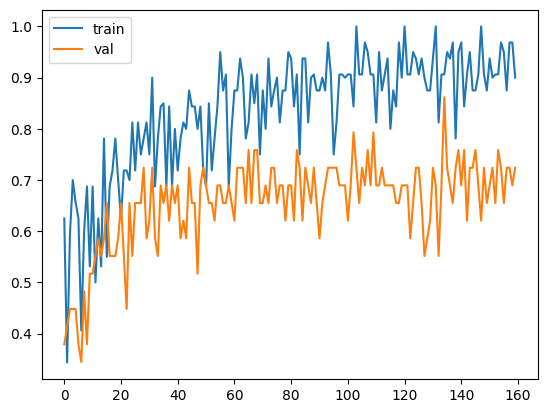

In [8]:
model = KeypointClassifier()
ce = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

accuracies_train = []
accuracies_val = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in dataloader_train:
        optimizer.zero_grad()
        logits = model(images)
        loss = ce(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # 50 epoch 마다 계산
        if epoch % 50 == 0:
            prediction = logits.argmax(dim=1)
            num_correct = (prediction == labels).type(torch.float).sum().item()
            accuracy_train = num_correct / len(labels)
            accuracies_train.append(accuracy_train)
            accuracy_val = validate(model, dataloader_val)
            accuracies_val.append(accuracy_val)
    
    # Print loss at the end of each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")

# Plot training and validation accuracies
plt.plot(accuracies_train, label="train")
plt.plot(accuracies_val, label="val")
plt.legend()
plt.show()

In [9]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X, y in dataloader_val:
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

accuracy = correct / total
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.79


In [10]:
def extract_keypoints_from_frame(frame):
    mp_pose = mp.solutions.pose
    with mp_pose.Pose(static_image_mode=False) as pose:
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(rgb_frame)
        if results.pose_landmarks:
            keypoints = [(lm.x, lm.y, lm.z) for lm in results.pose_landmarks.landmark]
            return np.array(keypoints).flatten()
        else:
            return np.zeros(99)

class poseDetector():
    def __init__(self, static_image_mode=False, model_complexity=1,
                 smooth_landmarks=True, detectionCon=0.5, trackCon=0.5):
        self.static_image_mode = static_image_mode
        self.model_complexity = model_complexity
        self.smooth_landmarks = smooth_landmarks
        self.detectionCon = detectionCon
        self.trackCon = trackCon
        self.mpDraw = mp.solutions.drawing_utils
        self.mpPose = mp.solutions.pose
        self.pose = self.mpPose.Pose(static_image_mode=self.static_image_mode,
                                     model_complexity=self.model_complexity,
                                     smooth_landmarks=self.smooth_landmarks,
                                     min_detection_confidence=self.detectionCon,
                                     min_tracking_confidence=self.trackCon)
    def findPose(self, img, draw=True):
        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        self.results = self.pose.process(imgRGB)
        if self.results.pose_landmarks:
            if draw:
                self.mpDraw.draw_landmarks(img, self.results.pose_landmarks,
                                           self.mpPose.POSE_CONNECTIONS)
        return img
    def findPosition(self, img, draw=True):
        self.lmList = []
        if self.results.pose_landmarks:
            for id, lm in enumerate(self.results.pose_landmarks.landmark):
                h, w, c = img.shape
                # print(id, lm)
                cx, cy = int(lm.x * w), int(lm.y * h)
                self.lmList.append([id, cx, cy])
                if draw:
                    cv2.circle(img, (cx, cy), 5, (255, 0, 0), cv2.FILLED)
        return self.lmList
    def findAngle(self, img, p1, p2, p3, draw=True):
        # Get the landmarks
        x1, y1 = self.lmList[p1][1:]
        x2, y2 = self.lmList[p2][1:]
        x3, y3 = self.lmList[p3][1:]
        # Calculate the Angle
        angle = math.degrees(math.atan2(y3 - y2, x3 - x2) -
                             math.atan2(y1 - y2, x1 - x2))
        if angle < 0:
            angle += 360
        # print(angle)
        # Draw
        if draw:
            cv2.line(img, (x1, y1), (x2, y2), (255, 255, 255), 3)
            cv2.line(img, (x3, y3), (x2, y2), (255, 255, 255), 3)
            cv2.circle(img, (x1, y1), 10, (0, 0, 255), cv2.FILLED)
            cv2.circle(img, (x1, y1), 15, (0, 0, 255), 2)
            cv2.circle(img, (x2, y2), 10, (0, 0, 255), cv2.FILLED)
            cv2.circle(img, (x2, y2), 15, (0, 0, 255), 2)
            cv2.circle(img, (x3, y3), 10, (0, 0, 255), cv2.FILLED)
            cv2.circle(img, (x3, y3), 15, (0, 0, 255), 2)
            cv2.putText(img, str(int(angle)), (x2 - 50, y2 + 50),
                        cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 2)
        return angle
    
def main():
    cap = cv2.VideoCapture(0, cv2.CAP_AVFOUNDATION)
    print("Real-time posture detection started. Press 'q' to exit.")

    pTime = 0
    detector = poseDetector()  # Assuming poseDetector is defined elsewhere

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Process the frame for keypoints
        keypoints = extract_keypoints_from_frame(frame)
        keypoints_tensor = torch.tensor(keypoints, dtype=torch.float32).unsqueeze(0)

        with torch.no_grad():
            output = model(keypoints_tensor)
            _, predicted = torch.max(output, 1)
            posture = "Correct" if predicted[0] == 1 else "Incorrect"

        # Add keypoints using poseDetector
        frame = detector.findPose(frame)
        lmList = detector.findPosition(frame)

        # Calculate FPS
        cTime = time.time()
        fps = 1 / (cTime - pTime)
        pTime = cTime

        # Add posture label and FPS to the frame
        cv2.putText(frame, f"Posture: {posture}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1,
                    (0, 255, 0) if posture == "Correct" else (0, 0, 255), 2)

        # Display the frame
        cv2.imshow("Posture Detection", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release resources
    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()

2024-12-12 16:14:43.609 python[26745:1501774] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


Real-time posture detection started. Press 'q' to exit.


I0000 00:00:1733987684.898054 1501774 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
I0000 00:00:1733987684.913158 1501774 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2 Pro
W0000 00:00:1733987684.990793 1510475 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733987685.008170 1510490 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733987685.014561 1510475 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733987685.028625 1510495 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for fe

KeyboardInterrupt: 